# Модель движения квадрокоптера
Движение квадрокоптера определяется силами гравитации, аэродинамического сопротивления и тягой пропеллеров
\begin{equation} \label{eq:common_traslational_motion}
m \ddot{{r}} = {F}_g + {F}_{aero} + {F}_{thr}. \quad (IF)
\end{equation}

Сила тяжести определяется общей массой аппарата $m$ и вектором ускорения свободного падения $g$
\begin{equation} \label{eq:gravity_force}
{F}_g = mg.
\end{equation}

Сила аэродинамического сопротивления зависит от площади сечения корпуса $S_{\perp}$, плотности воздуха $\rho_{air}$ и аэродинамической константы $C$

\begin{equation} \label{eq:aerodynamic_force}
{F}_{aero} = - \frac{1}{2} \rho_{air} C S_{\perp} |\dot{{r}}| \dot{{r}}.
\end{equation}

Сила тяги пропеллеров зависит от их оборотов $\tilde\omega$ и аэродинамического коэффициента $k$,
а ее направление зависит от ориентации корпуса $q$
\begin{equation} \label{eq:thrust_force}
{F}_{thr} = q \circ \Big(\sum_{i=1}^{4}{ f_i } \Big) \circ \tilde q =
 q \circ \Big( \sum_{i=1}^{4}{ { k \tilde\omega^2_i e_z} \Big) \circ \tilde q
.} 
\end{equation}
 

Вращательное движение зависит от моментов сил со стороны роторов с пропеллерами

\begin{equation} \label{eq:common_rotational_motion}
\sum_{i=1}^{4}{{r_i} \times {f}_{i}} - \sum_{i=1}^{4}{{\tau}_{i}} 
= {J}\dot{{\Omega}} + {\Omega} \times  {J}{{\Omega}}, \quad (BF)
\end{equation}

\begin{equation} \label{eq:poison_eq}
\dot{q} = \frac{1}{2} q \circ \Omega, \\
\end{equation}

\begin{equation} \label{eq:m_rotors_dyn}
{\tau}_i + {\varsigma}_{i} = 
{j_i} \dot{\omega}_i + \omega_i \times j_i \omega_i, \quad (RF)
\end{equation}

\begin{equation} \label{eq:rotor_ext_torque}
{\varsigma}_{i} = -b \tilde{\omega}^2_i {z_i}.
\end{equation}

Или, в упрощенном виде
\begin{equation} \label{eq:simple_rotational_motion}
T \tilde \omega
= {J}\dot{{\Omega}} + {\Omega} \times  {J}{{\Omega}}, \quad (BF) \\
\quad \\
\tilde \omega = 
\begin{bmatrix}
\tilde \omega^{2}_{1}\\
\tilde \omega^{2}_{2}\\
\tilde \omega^{2}_{3}\\
\tilde \omega^{2}_{4}
\end{bmatrix}, \\
\quad \\
T = 
\begin{bmatrix}
0 & kL & 0 & -kL\\
-kL & 0 & kL & 0\\
b & -b & b & -b
\end{bmatrix}.
\end{equation}


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
# Вспомогательные функции

def normalize(obj):

    return obj / np.linalg.norm(obj)


def cross_product(a, b):

    def check_dimensions(vec, string):

        if vec.ndim != 1:
            raise Exception("The {} input is not a vector".format(string))
        if len(vec) != 3:
            raise Exception("Wrong number of coordinates in the {0} vector: {1}, should be 3".format(string, len(vec)))

    check_dimensions(a, 'first')
    check_dimensions(b, 'second')

    return np.array([a[1]*b[2]-a[2]*b[1], a[2]*b[0]-a[0]*b[2], a[0]*b[1] - a[1]*b[0]])

def quat_product(q1, q2):

    def check_dimensions(q, string):

        if q.ndim != 1:
            raise Exception("The {} input is not a quaternion".format(string))
        if len(q) != 4:
            raise Exception("Wrong number of coordinates in the {0} quaternion: {1}, should be 4".format(string, len(q)))

    check_dimensions(q1, 'first')
    check_dimensions(q2, 'second')

    q = np.zeros(4)
    q[0] = q1[0] * q2[0] - q1[1:].dot(q2[1:])
    q[1:] = q1[0] * q2[1:] + q2[0] * q1[1:] + cross_product(q1[1:], q2[1:])

    return q

def rotate_vec_with_quat(q, vec):

    def check_dimensions(obj, is_quat):

        if obj.ndim != 1:
            raise Exception("Not a {}".format('quaternion' * is_quat + 'vector' * (1 - is_quat)))
        if len(obj) != (3 + 1 * is_quat):
            raise Exception("Wrong number of coordinates in the {0}: {1}, should be {2}"
                            .format('quaternion' * is_quat + 'vector' * (1 - is_quat), len(obj), 3 + 1 * is_quat))

    check_dimensions(q, True)
    check_dimensions(vec, False)

    q = quat_conjugate(q)

    qxvec = cross_product(q[1:], vec)

    return q[1:].dot(vec) * q[1:] + q[0]**2. * vec + 2. * q[0] * qxvec + cross_product(q[1:], qxvec)

def quat2rpy(q0, q1, q2, q3):

    roll = np.arctan2(2. * (q0 * q1 + q2 * q3), 1. - 2. * (q1**2 + q2**2))
    pitch = np.arcsin(2. * (q0 * q2 - q1 * q3))
    yaw = np.arctan2(2. * (q0 * q3 + q1 * q2), 1. - 2. * (q2**2 + q3**2))

    return [roll, pitch, yaw]

def quat2rpy_deg(q0, q1, q2, q3):

    roll = np.arctan2(2. * (q0 * q1 + q2 * q3), 1. - 2. * (q1**2 + q2**2))*180/np.pi
    pitch = np.arcsin(2. * (q0 * q2 - q1 * q3))*180/np.pi
    yaw = np.arctan2(2. * (q0 * q3 + q1 * q2), 1. - 2. * (q2**2 + q3**2))*180/np.pi

    return [roll, pitch, yaw]

def quat_conjugate(q):

    q_new = np.copy(q)
    q_new[1:] *= -1.

    return q_new

# Управление квадрокоптером
[Mellinger D., Kumar V. Minimum snap trajectory generation, control for
quadrotors (https://ieeexplore.ieee.org/document/5980409)]

Построим вектор управления таким образом,
что первая его компонента будет отвечать за абсолютную величину тяги пропеллеров,
а остальные три -- за три компоненты момента силы, действующие на корпус квадрокоптера
\begin{equation} \label{eq:mellinger_control_vector}
	\begin{aligned}
	u = [|f| \quad \tau]^T = 
	\begin{bmatrix}
	k & k & k & k\\
	0 & kL & 0 & -kL\\
	-kL & 0 & kL & 0\\
	b & -b & b & -b
	\end{bmatrix}
	\begin{bmatrix}
	\tilde \omega^{2}_{1}\\
	\tilde \omega^{2}_{2}\\
	\tilde \omega^{2}_{3}\\
	\tilde \omega^{2}_{4}
	\end{bmatrix}.
	\end{aligned} \quad (BF)
\end{equation}

Для того, чтобы управлять положением квадрокоптера, построим ПД регулятор
\begin{equation} \label{eq:pos_reg_1}
\ddot{r}_{des} = k_r e_r + k_v e_v,
\end{equation}
где
\begin{equation} \label{eq:mellinger_pos_err}
{e}_r = {r}_{des} - {r},
\end{equation}
\begin{equation} \label{eq:mellinger_vel_err}
{e}_v = {v}_{des} - {v}.
\end{equation}

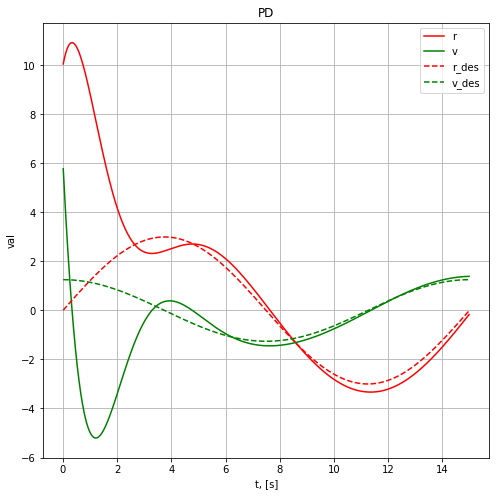

In [11]:
# целевые траектории
def des_traj_fcn_0(t):
    return np.array([0, 0])

def des_traj_fcn_1(t):
    k = 0.05
    return np.array([k * t**2, 2 * k * t])

def des_traj_fcn_2(t):
    k = 3
    p = 15
    return np.array([k * np.sin(t * 2 * np.pi / p), k * 2 * np.pi / p * np.cos(t * 2 * np.pi/p)])

# выбор целевой траектории
def des_traj_fcn(t):
    return des_traj_fcn_2(t)

# регулятор
def pd(t, x, kr, kv):
    
    x_des = des_traj_fcn(t)

    er = x_des[0] - x[0]
    ev = x_des[1] - x[1]
    
    x_dot = np.array([0.,0.])
    x_dot[0] = x[1]
    x_dot[1] = kr * er + kv * ev
    
    return x_dot

# t
t0 = 0.
tf = 15.
t_eval = np.arange(t0, tf, 0.01)

# des
x_des = np.array([0, 0])
i = 0;
for t in t_eval:
    if i == 0:
        x_des = des_traj_fcn(t)
    else:
        x_des = np.vstack((x_des, des_traj_fcn(t)))
    i += 1
    
# Выбор коэффициентов PD регулятора
kr = 1.5;
kv = 1.5;

# initial
x_0 = np.array([10., 6.])

# solve
sol = solve_ivp(lambda t, x: pd(t, x, kr, kv), (t0,tf), x_0, t_eval = t_eval)
x = sol.y.T
t = sol.t[1:]

# plot
fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)

ax1.set_title("PD")
ax1.plot(t, x[1:,0], label = 'r', color = 'red')
ax1.plot(t, x[1:,1], label = 'v', color = 'green')
ax1.plot(t, x_des[1:,0], 'r--', label = 'r_des')
ax1.plot(t, x_des[1:,1], 'g--', label = 'v_des')
ax1.set_ylabel(r'val')
ax1.set_xlabel(r't, [s]')
ax1.grid(True)
ax1.legend()

Тогда,
\begin{equation} \label{eq:mellinger_pos_reg}
{F}_{des} = m k_r {e}_r + m k_v {e}_v - F_g - F_{aero}.
\end{equation}

Чтобы обеспечить соответствие управляющего вектора выходу регулятора,
нужно изменить ориентацию корпуса квадрокоптера так,
чтобы направление его тяги совпадало с требуемой

\begin{equation} \label{eq:mellinger_Rdes}
q_{des} \circ e_z \circ \tilde q_{des} = \frac{{F}_{des}}{||{F}_{des}||}.
\end{equation}

Решений для $q_{des}$ будет множество,
т.к. наклонить таким образом корпус можно, изменяя тангаж и крен,
при этом угол рысканья может быть произвольным.
Вычислив $q_{des}$, например, для фиксированного угла рысканья,
можно воспользоваться рассмотренным ранее регулятором
для отслеживания необходимой ориентации

\begin{equation} \label{eq:qf_reg}
\tau_{des} = -{\Omega} \times  {J}{{\Omega}} + k_{\Omega} e_{\Omega} + k_{q} e_{q}.
\end{equation}

Тогда, $u = [{F}_{des} \cdot {z}_B \quad \tau_{des}]^T$.

In [15]:
q_des_list = np.array([0, 0, 0, 0])
r_des_list = np.array([0, 0, 0])
v_des_list = np.array([0, 0, 0])
tilde_w_sat_list = np.array([0, 0, 0, 0])

# Управление квадрокоптером
def des_traj_fcn_0(t):
    return np.zeros((6,))

def des_traj_fcn_1(t):
    k = 10
    p = 60
    
    rx = k * np.sin(t * 2 * np.pi / p)
    ry = k * np.sin(2 * t * 2 * np.pi / p)
    rz = 0.3*rx
    
    vx = 2 * np.pi / p * k * np.cos(t * 2 * np.pi / p)
    vy = 2 * 2 * np.pi / p * k * np.cos(2 * t * 2 * np.pi / p)
    vz = 0.3 * vx
    
    return np.array([rx, ry, rz, vx, vy, vz])

def des_traj_fcn(t):
    return des_traj_fcn_0(t)

def uav_euler_int(x0, T, dt, UAV):
    xs = np.array([x0])
    ts = np.array([0.])
    while ts[-1] < T:
        
        x_dot = model(ts[-1], xs[-1,:], UAV)
        x_next = xs[-1,:] + x_dot * dt
        t_next = ts[-1] + dt
        xs = np.vstack((xs, x_next))
        ts = np.append(ts, t_next)
    return ts, xs
        
def model(t, x, UAV):
    # x [r v q omega]
    r = x[0:3]
    v = x[3:6]
    q = x[6:10]
    w = x[10:13]
    
    # reg
    x_des = des_traj_fcn(t)
    r_des = x_des[0:3]
    v_des = x_des[3:6]
    f_des = pose_reg(t, x, UAV, r_des, v_des)
    q_des = quat_des(f_des, yaw=1.)
    tau_des = qf_reg(t, x, q_des, UAV)

    # ctrl vec
    u = np.array([np.linalg.norm(f_des), tau_des[0], tau_des[1], tau_des[2]])
    tilde_w2 = UAV.A_inv @ u
    tilde_w = np.sqrt(tilde_w2)
    tilde_w_sat = np.clip(tilde_w, 0., UAV.w_lim)
    tilde_w2_sat = np.power(tilde_w_sat, 2)
    u_sat =  UAV.A @ tilde_w2_sat
        
    # f tau
    ft_abs = u_sat[0]
    ft = rotate_vec_with_quat(quat_conjugate(q), np.array([0.,0.,ft_abs]))
    Fg = - np.array([0., 0., 10]) * UAV.m
    Fa = - 0.5 * UAV.C * UAV.S * UAV.rho * v * np.linalg.norm(v)
    f = ft + Fg + Fa
    
    taut = u_sat[1:4]
    tau = taut - cross_product(w, np.matmul(UAV.J, w))
    
    # x_dot
    a = f/UAV.m
    nu = np.matmul(UAV.J_inv, tau)
    x_dot = np.zeros((13,))
    x_dot[0:3] = v
    x_dot[3:6] = a
    x_dot[6] = -0.5 * q[1:4].dot(w)
    x_dot[7:10] =  0.5 * (q[0] * w + cross_product(q[1:4], w))
    x_dot[10:13] = nu
    
    # hist
    global q_des_list
    global r_des_list
    global v_des_list
    global tilde_w_sat_list
    q_des_list = np.vstack((q_des_list, q_des))
    r_des_list = np.vstack((r_des_list, r_des))
    v_des_list = np.vstack((v_des_list, v_des))
    tilde_w_sat_list = np.vstack((tilde_w_sat_list, tilde_w_sat))
    
    return x_dot

def quat_des(v, yaw):

    q_yaw = np.array([np.cos(yaw / 2.0), 0.0, 0.0, np.sin(yaw / 2.0)])
    if (np.linalg.norm(v) < 1e-3):
        return q_yaw
    
    ez = np.array([0., 0., 1.])
    pin = np.cross(ez, v)
    if (np.linalg.norm(pin) < 1e-3):
        return q_yaw
    
    pin = pin / np.linalg.norm(pin)
    vn = v / np.linalg.norm(v)
    
    cosA = np.dot(vn, ez)
    A = np.arccos(cosA)
    
    sinHalfA = np.sin(A / 2.0)
    q_bow = np.array([np.cos(A / 2.0), sinHalfA * pin[0], sinHalfA * pin[1], sinHalfA * pin[2]])
        
    return quat_product(q_bow, q_yaw)

def pose_reg(t, x, UAV, r_des, v_des):
    # x [r v q omega]
    r = x[0:3]
    v = x[3:6]
    q = x[6:10]
    w = x[10:13]
    
    er = r_des - r
    ev = v_des - v
    
    Fg = - np.array([0., 0., 10]) * UAV.m
    Fa = - 0.5 * UAV.C * UAV.S * UAV.rho * v * np.linalg.norm(v)
    
    ez_I = rotate_vec_with_quat(quat_conjugate(q), np.array([0., 0., 1]))
    
    f = UAV.m * UAV.kr * er + UAV.m * UAV.kv * ev - Fg - Fa
    
    return f

def qf_reg(t, x, q_des, UAV):
    # x [r v q omega]
    r = x[0:3]
    v = x[3:6]
    q = x[6:10]
    w = x[10:13]

    x_des = np.zeros((7))
    x_des[0:4] = q_des
    
    dw = -w
    dq = -quat_product(quat_conjugate(x_des[0:4]), q)
    
    tau = cross_product(w, np.matmul(UAV.J, w)) + UAV.ko * np.matmul(UAV.J, dw) + UAV.kq * np.matmul(UAV.J, dq[1:])
    
    return tau



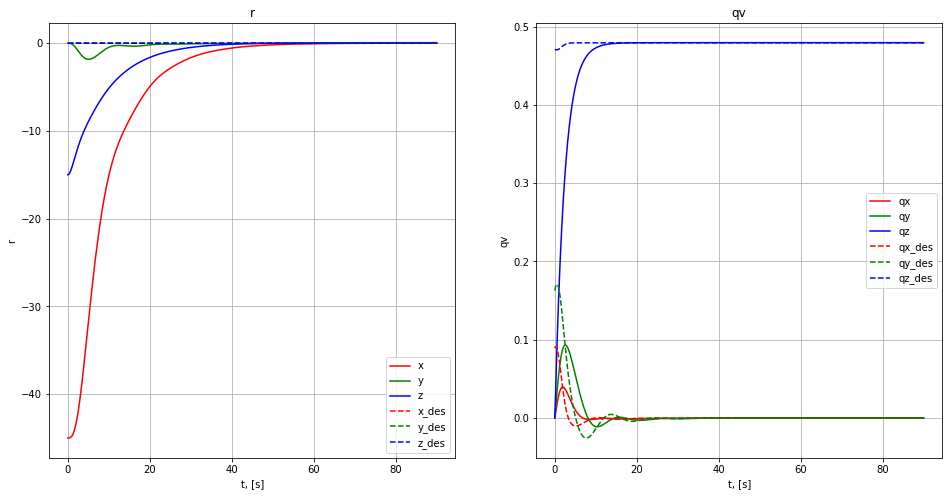

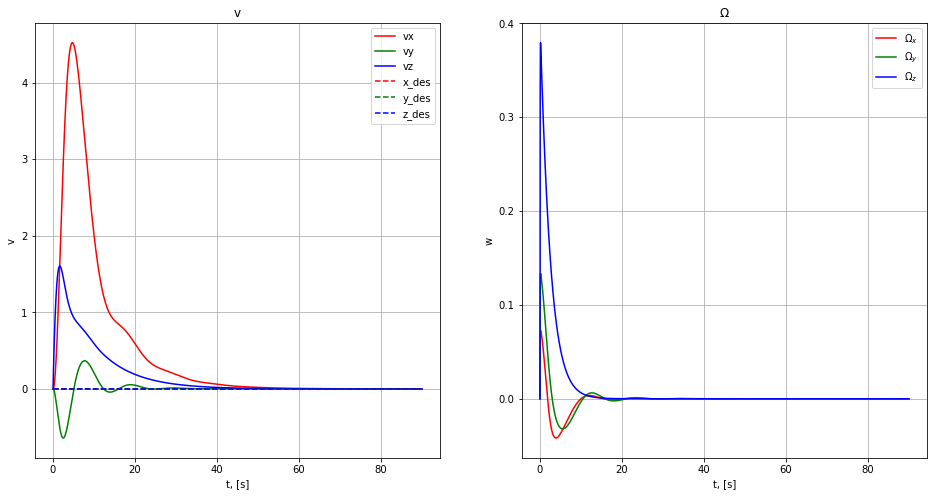

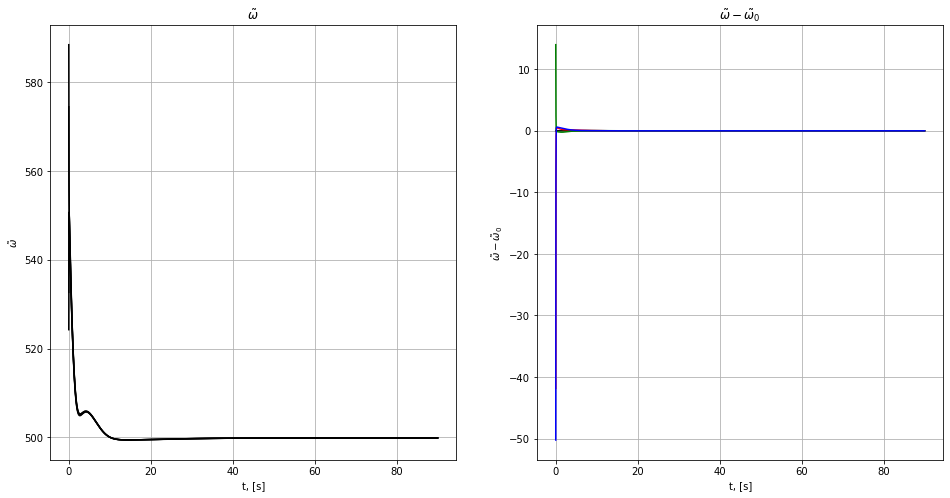

In [16]:
q_des_list = np.array([0, 0, 0, 0])
r_des_list = np.array([0, 0, 0])
v_des_list = np.array([0, 0, 0])
tilde_w_sat_list = np.array([0, 0, 0, 0])

# Моделирование
# params
class UAV:
    m = 1.0
    J = np.diag(np.array([1, 1, 1])) * 1e-2
    J_inv = np.linalg.inv(J)
    L = 0.25
    k = 1e-5
    b = 1e-6
    w_lim = 1e3
    S = 0.12
    C = 1.0
    rho = 1.0
    
    kr = 0.1
    kv = 1.
    kq = 25.
    ko = 30.
    
    A = np.array([[k, k, k, k],
                  [0, k*L, 0, -k*L],
                  [-k*L, 0, k*L, 0],
                  [b, -b, b, -b]])
    A_inv = np.linalg.inv(A)

UAVobject = UAV();    
    
# t
t0 = 0.
tf = 90.
dt = 0.01
t_eval = np.arange(t0, tf, dt)

# initial
x_0 = np.array([-45., 0., -15., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
ts, xs = uav_euler_int(x_0, tf, dt, UAVobject)

# plot
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,2,1)
ax2 = fig1.add_subplot(1,2,2)

# r
ax1.set_title("r")
n = 0
ax1.plot(ts, xs[:,n], 'r', label = 'x')
ax1.plot(ts, xs[:,n+1], 'g', label = 'y')
ax1.plot(ts, xs[:,n+2], 'b', label = 'z')

ax1.plot(ts[1:], r_des_list[1:,0], 'r--', label = 'x_des')
ax1.plot(ts[1:], r_des_list[1:,1], 'g--', label = 'y_des')
ax1.plot(ts[1:], r_des_list[1:,2], 'b--', label = 'z_des')

ax1.set_ylabel(r'r')
ax1.set_xlabel(r't, [s]')
ax1.grid(True)
ax1.legend()

# q
ax2.set_title("qv")
n = 7
ax2.plot(ts, xs[:,n], 'r', label = 'qx')
ax2.plot(ts, xs[:,n+1], 'g', label = 'qy')
ax2.plot(ts, xs[:,n+2], 'b', label = 'qz')

ax2.plot(ts[1:], q_des_list[1:,1], 'r--', label = 'qx_des')
ax2.plot(ts[1:], q_des_list[1:,2], 'g--', label = 'qy_des')
ax2.plot(ts[1:], q_des_list[1:,3], 'b--', label = 'qz_des')

ax2.set_ylabel(r'qv')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

fig3 = plt.figure(figsize=(16,8))
ax3 = fig3.add_subplot(1,2,1)
ax4 = fig3.add_subplot(1,2,2)

# v
ax3.set_title("v")
n = 3
ax3.plot(ts, xs[:,n], 'r', label = 'vx')
ax3.plot(ts, xs[:,n+1], 'g', label = 'vy')
ax3.plot(ts, xs[:,n+2], 'b', label = 'vz')

ax3.plot(ts[1:], v_des_list[1:,0], 'r--', label = 'x_des')
ax3.plot(ts[1:], v_des_list[1:,1], 'g--', label = 'y_des')
ax3.plot(ts[1:], v_des_list[1:,2], 'b--', label = 'z_des')

ax3.set_ylabel(r'v')
ax3.set_xlabel(r't, [s]')
ax3.grid(True)
ax3.legend()

# w
ax4.set_title(r'$\Omega$')
n = 10
ax4.plot(ts, xs[:,n], 'r', label = r'$\Omega_x$')
ax4.plot(ts, xs[:,n+1], 'g', label = r'$\Omega_y$')
ax4.plot(ts, xs[:,n+2], 'b', label = r'$\Omega_z$')
ax4.set_ylabel(r'w')
ax4.set_xlabel(r't, [s]')
ax4.grid(True)
ax4.legend()

# rotors
fig4 = plt.figure(figsize=(16,8))
ax5 = fig4.add_subplot(1,2,1)
ax6 = fig4.add_subplot(1,2,2)

ax5.set_title(r'$\tilde{\omega}$')
ax6.set_title(r'$\tilde{\omega} - \tilde{\omega}_0$')

ax5.plot(ts[1:], tilde_w_sat_list[1:,0], 'k', label = '')
ax5.plot(ts[1:], tilde_w_sat_list[1:,1], 'k', label = '')
ax5.plot(ts[1:], tilde_w_sat_list[1:,2], 'k', label = '')
ax5.plot(ts[1:], tilde_w_sat_list[1:,3], 'k', label = '')

ax6.plot(ts[1:], tilde_w_sat_list[1:,0]-tilde_w_sat_list[1:,0], 'k', label = '')
ax6.plot(ts[1:], tilde_w_sat_list[1:,1]-tilde_w_sat_list[1:,0], 'r', label = '')
ax6.plot(ts[1:], tilde_w_sat_list[1:,2]-tilde_w_sat_list[1:,0], 'g', label = '')
ax6.plot(ts[1:], tilde_w_sat_list[1:,3]-tilde_w_sat_list[1:,0], 'b', label = '')

ax5.set_ylabel(r'$\tilde{\omega}$')
ax5.set_xlabel(r't, [s]')
ax6.set_ylabel(r'$\tilde{\omega} - \tilde{\omega}_0$')
ax6.set_xlabel(r't, [s]')
ax5.grid(True)
ax6.grid(True)
#ax5.legend()
#ax6.legend()

(-10.0, 10.0)

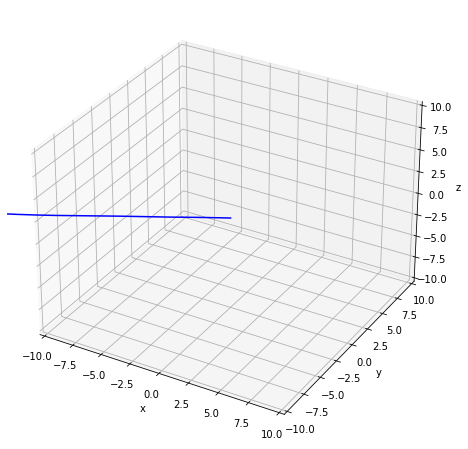

In [17]:
# 3d
fig3d = plt.figure(figsize=(8,8))
ax3d = fig3d.add_subplot(111, projection='3d')
ax3d.plot(xs[:,0], xs[:,1], xs[:,2], 'b', label = 'traj')
ax3d.plot(r_des_list[1:,0], r_des_list[1:,1], r_des_list[1:,2], 'k', label = 'des_traj')
ax3d.set_xlabel(r'x')
ax3d.set_ylabel(r'y')
ax3d.set_zlabel(r'z')
ax3d.grid(True)
lim = 10.
ax3d.set_xlim(-lim, lim)
ax3d.set_ylim(-lim, lim)
ax3d.set_zlim(-lim, lim)
#ax5.legend()

В качестве упражнения предлагается усовершенствовать контур управления квадрокоптером.

С помощью выражения
\begin{equation} \label{eq:mellinger_Rdes}
q_{des} \circ e_z \circ \tilde q_{des} = \frac{{F}_{des}}{||{F}_{des}||}.
\end{equation}
производится расчет целевой ориентации БЛА, при этом на вход quarternion feedback регулятора можно подавать также целевую угловую скорость.

Как найти целевую угловую скорость и как ее использование в регуляторе повлияет на производительность алгоритма управления?